## On policy and Off Policy Control

### Exploding Stars Control

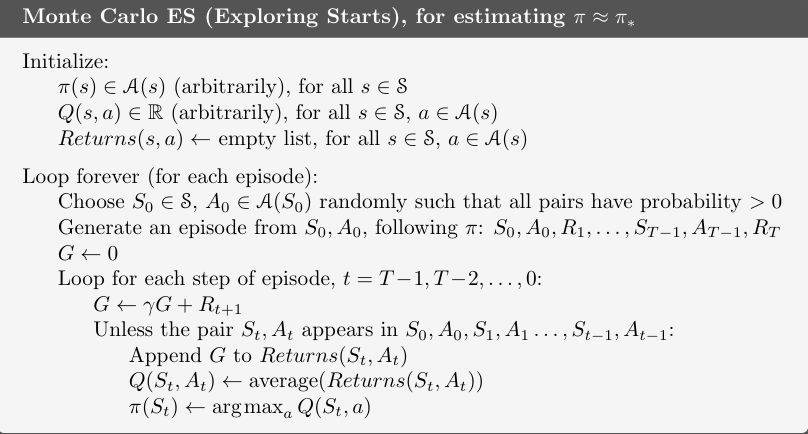

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from Monte_carlo_helper import *

In [7]:
def MC_ES(env,gamma=1,n_episodes=100000,method="first-visit"):
    # Q = {(p,d,a):{0:0.1 ,1:0.1} for p in range(32) for d in range(11) for a in range(2)}
    Q={}
    count = {}
    pi = {(p,d,a): [0,1] for p in range(32) for d in range(11) for a in range(2)}
    for _ in range(n_episodes):
        states,actions,rewards = generate_episode(env,pi)
        G =0
        visited_state_action = set()
        for t in range(len(states)-1,-1,-1):
            S = states[t]
            A = actions[t]
            G = G*gamma +rewards[t]
            if method == "first-visit" and (S,A) in visited_state_action:
                continue  # Skip if already visited (first-visit MC)
            visited_state_action.add((S,A))
            if S not in count:
                count[S] = {0:0,1:0}
                Q[S] = {0:1,1:1}
            count[S][A]+=1
            Q[S][A] += (G-Q[S][A])/(np.maximum(count[S][A], 1))
            # Q[state[t]][action[t]] += (G-Q[state[t]][action[t]])/(np.maximum(count[S], 1))    
        for state in Q.keys():
            # if state not in pi.keys():
            #     pi[state] = [1,0]
                # pi[state] = np.argmax([Q[state][action] for action in range(env.action_space.n)])
            amax = np.argmax([Q[state][action] if state in Q.keys() else 0  for action in range(env.action_space.n)])
            pi[state] = [1,0] if amax==0 else [0,1]


            
    return pi,Q

In [8]:
env = gym.make('Blackjack-v1',sab=True)

In [9]:
optimal_policy , Q = MC_ES(env,n_episodes=500000,method="first-visit")


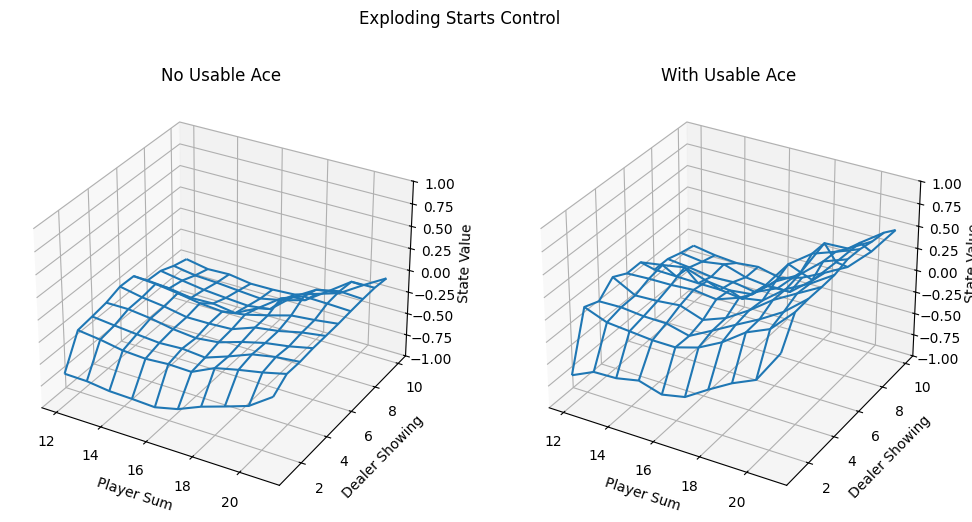

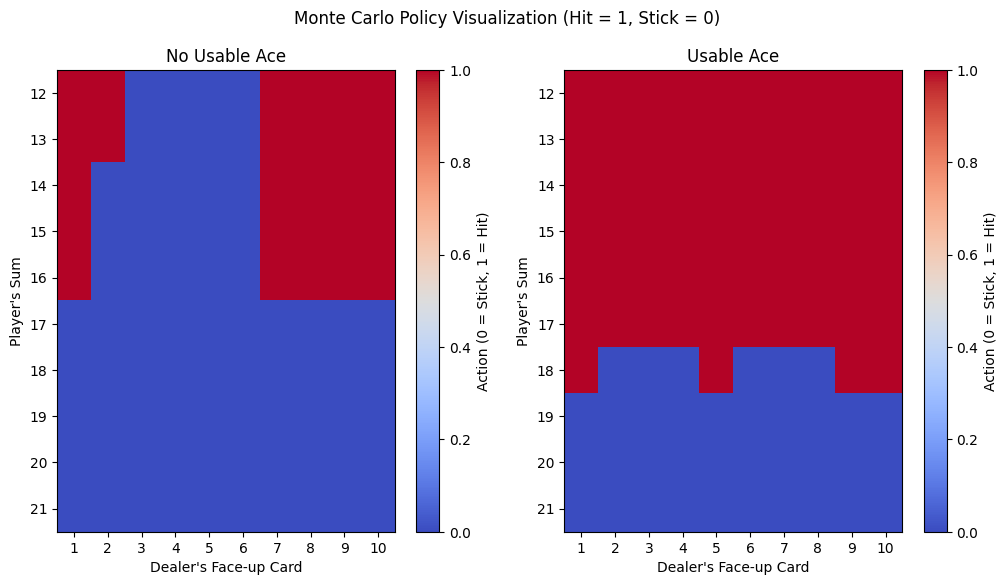

In [ ]:
plot_blackjack_Q(Q,"Exploding Starts Control")
plot_policy(optimal_policy)

### On Policy Control

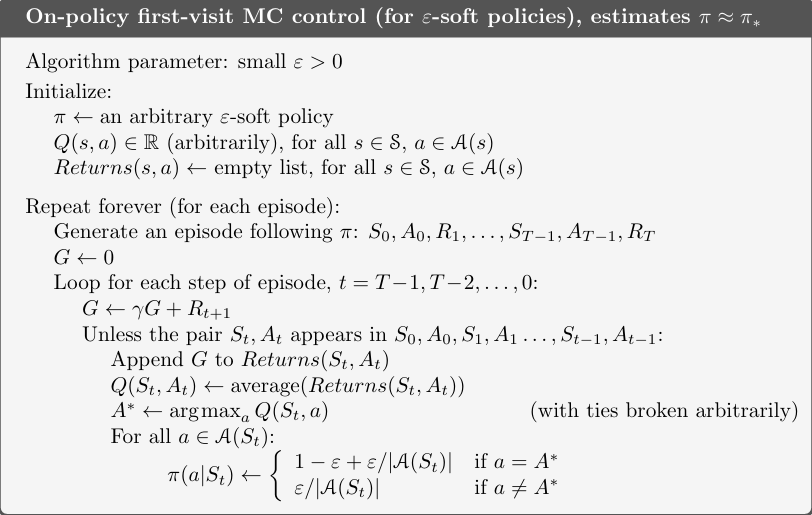

In [16]:
def MC_control_on(env,gamma=1,n_episodes=100000,method="first-visit",epsilon=0.01):
    Q = {(p,d,a):{0:1,1:1} for p in range(32) for d in range(11) for a in range(2)}
    count = {(p,d,a):{0:0,1:0}  for p in range(32) for d in range(11) for a in range(2)}
    policy = {(p,d,a):[0,1]  for p in range(32) for d in range(11) for a in range(2)}
    for _ in range(n_episodes):
        states,actions,rewards = generate_episode(env,policy)
        G = 0
        visited_states = set()
        for t in range(len(states)-1,-1,-1):
            S = states[t]
            A = actions[t]
            G = G*gamma +rewards[t]
            if method == "first-visit" and (S,A) in visited_states:
                continue  # Skip if already visited (first-visit MC)
            visited_states.add((S,A))
            if S not in count:
                count[S] = {0:0,1:0}
                Q[S] = {0:0,1:0}
            count[S][A]+=1
            Q[S][A] += (G-Q[S][A])/(np.maximum(count[S][A], 1))
            for state in Q.keys():
                amax = np.argmax([Q[state][action] if state in Q.keys() else 0  for action in range(env.action_space.n)])
                for a in range(env.action_space.n):
                    policy[state][a] = 1-epsilon+epsilon/len(Q[S]) if a == amax else epsilon/len(Q[S])
            
            
    return policy,Q

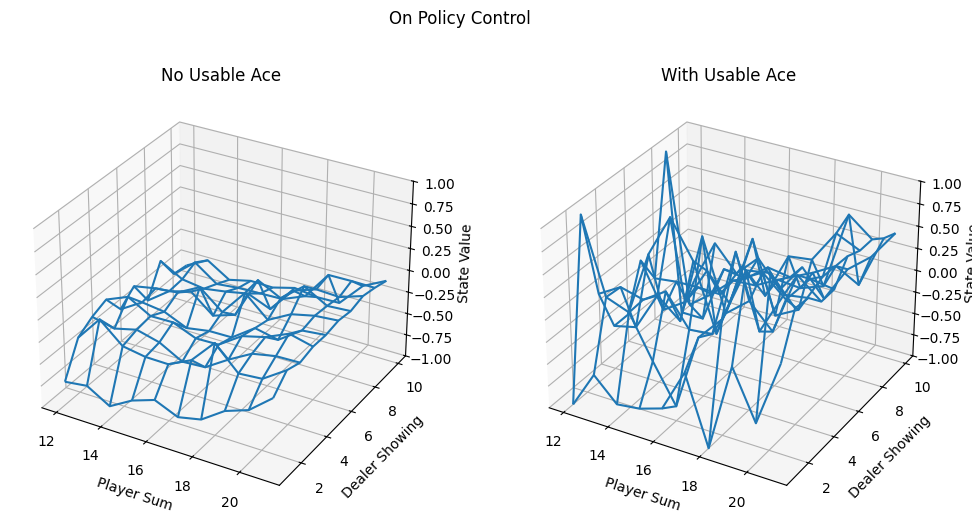

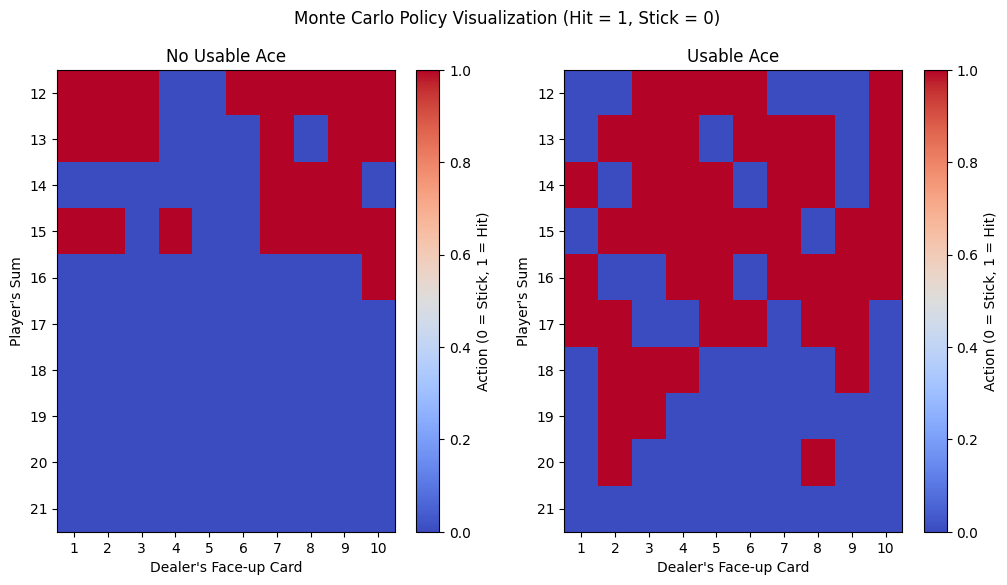

In [18]:
optimal_on_policy , Q_on = MC_control_on(env,n_episodes=10000,method="first-visit")
plot_blackjack_Q(Q_on,"On Policy Control")
plot_policy(optimal_on_policy)

### Off Policy Control

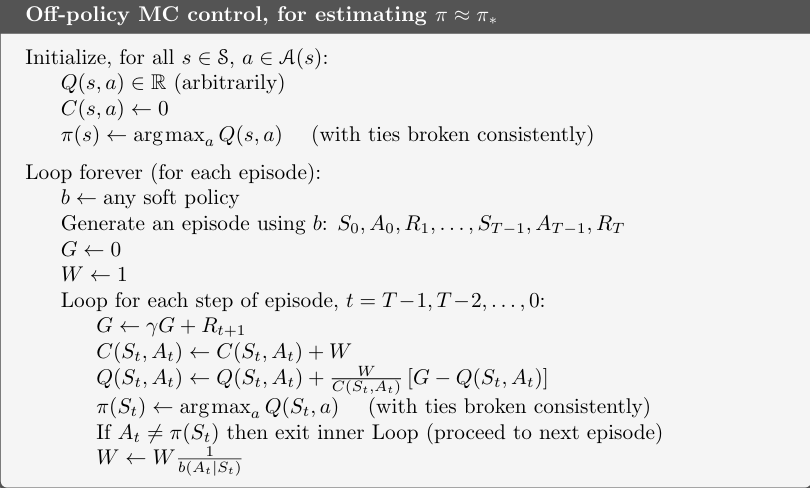

In [47]:
def MC_control_off(env,target_policy=None,behavior_policy=None,gamma=1,n_episodes=100000):
    Q = {(p,d,a):{0:0.5,1:0.5} for p in range(32) for d in range(11) for a in range(2)}
    C = {(p,d,a):{0:0,1:0}  for p in range(32) for d in range(11) for a in range(2)}
    policy = {} 
    for state in Q.keys():
        amax = np.argmax([Q[state][action] if state in Q.keys() else 0  for action in range(env.action_space.n)])
        if state not in policy.keys():
            policy[state] = [0,0]
        policy[state] = [1,0] if amax==0 else [0,1]
    for _ in range(n_episodes):
        states,actions,rewards = generate_episode(env,behavior_policy)
        G = 0
        W = 1
        for t in range(len(states)-1,-1,-1):
            S = states[t]
            A = actions[t]
            G = G*gamma +rewards[t]
            C[S][A]+=W
            Q[S][A] += (W/C[S][A])*(G-Q[S][A])
            amax = np.argmax([Q[S][action] if S in Q.keys() else 0  for action in range(env.action_space.n)])
            policy[S] = [1,0] if amax==0 else [0,1]
            if A!=amax:
                break
            W *= 1/behavior_policy[S][A] # Importance sampling ratio this is not pi(a/s)/b(a/s) 
                                         #because pi(a/s) is always 1(deterministic policy)
            
    return policy,Q

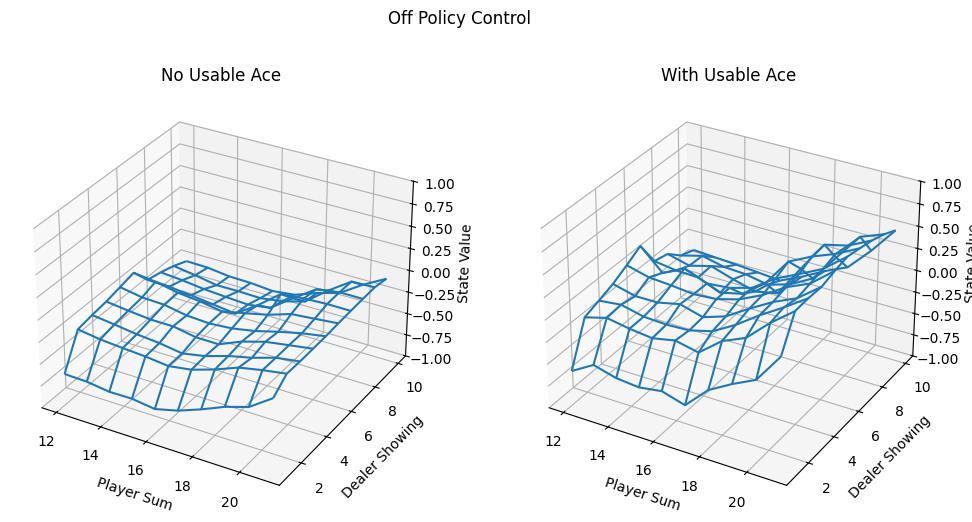

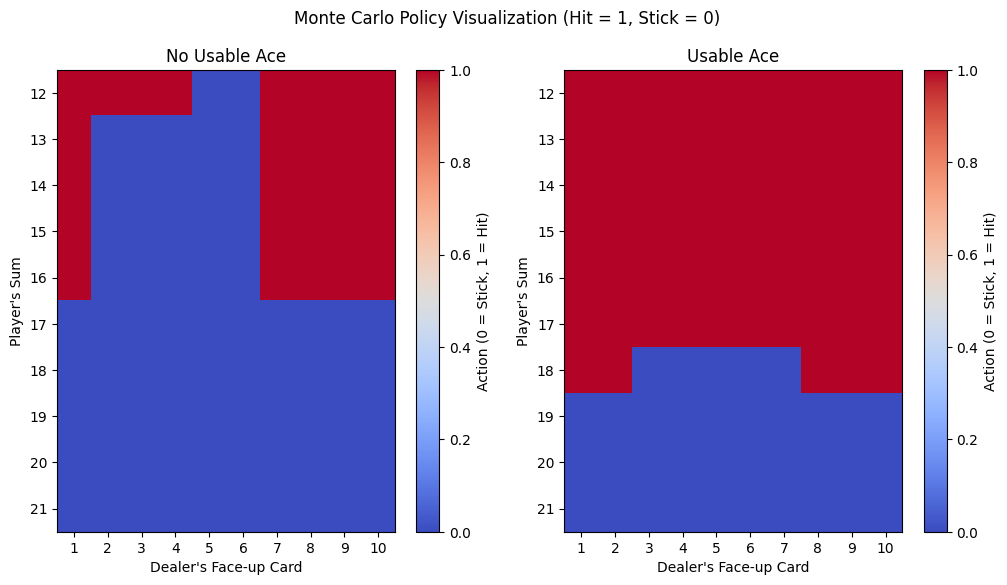

In [48]:
target_policy = {(p,d,a):[0,1] if p<20 else [1,0] for p in range(32) for d in range(11) for a in range(2)}
behaviour_policy = {(p,d,a):[0.5,0.5] for p in range(32) for d in range(11) for a in range(2)}
optimal_off_policy,Q_off = MC_control_off(env,target_policy,behaviour_policy, n_episodes=1000000)
plot_blackjack_Q(Q_off,"Off Policy Control")
plot_policy(optimal_off_policy)